In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load data-sets
test_df = pd.read_csv('taxi_fare/test.csv')
train_df = pd.read_csv('taxi_fare/train.csv')


In [3]:
# Check df entries
train_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [4]:
# Check df entries
test_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0


In [5]:
# Check for missing values
train_df[train_df.isna().any(axis=1)]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied


In [6]:
# Check for duplicates
train_df[train_df.duplicated()].shape

(4325, 8)

In [7]:
# Drop duplicates
train_clean = train_df.drop_duplicates()
train_clean.shape

(205348, 8)

In [8]:
# Check data types for each column 
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205348 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       205348 non-null  float64
 1   distance_traveled   205348 non-null  float64
 2   num_of_passengers   205348 non-null  float64
 3   fare                205348 non-null  float64
 4   tip                 205348 non-null  int64  
 5   miscellaneous_fees  205348 non-null  float64
 6   total_fare          205348 non-null  float64
 7   surge_applied       205348 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 14.1 MB


In [9]:
# Check out useful statistics for each column
train_clean.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000
mean,1189.102226,5.123167,1.298654,100.656568,13.247560,15.294384,129.198512,0.285803
std,4824.302160,126.528223,0.939258,86.142902,20.507879,12.621609,99.283531,0.451797
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000
25%,454.000000,1.980000,1.000000,52.500000,0.000000,6.000000,73.125000,0.000000
50%,716.000000,3.250000,1.000000,78.750000,9.000000,9.750000,103.500000,0.000000
75%,1110.000000,5.810000,1.000000,116.250000,20.000000,26.525000,153.450000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000,1.000000


c:\Users\patri\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


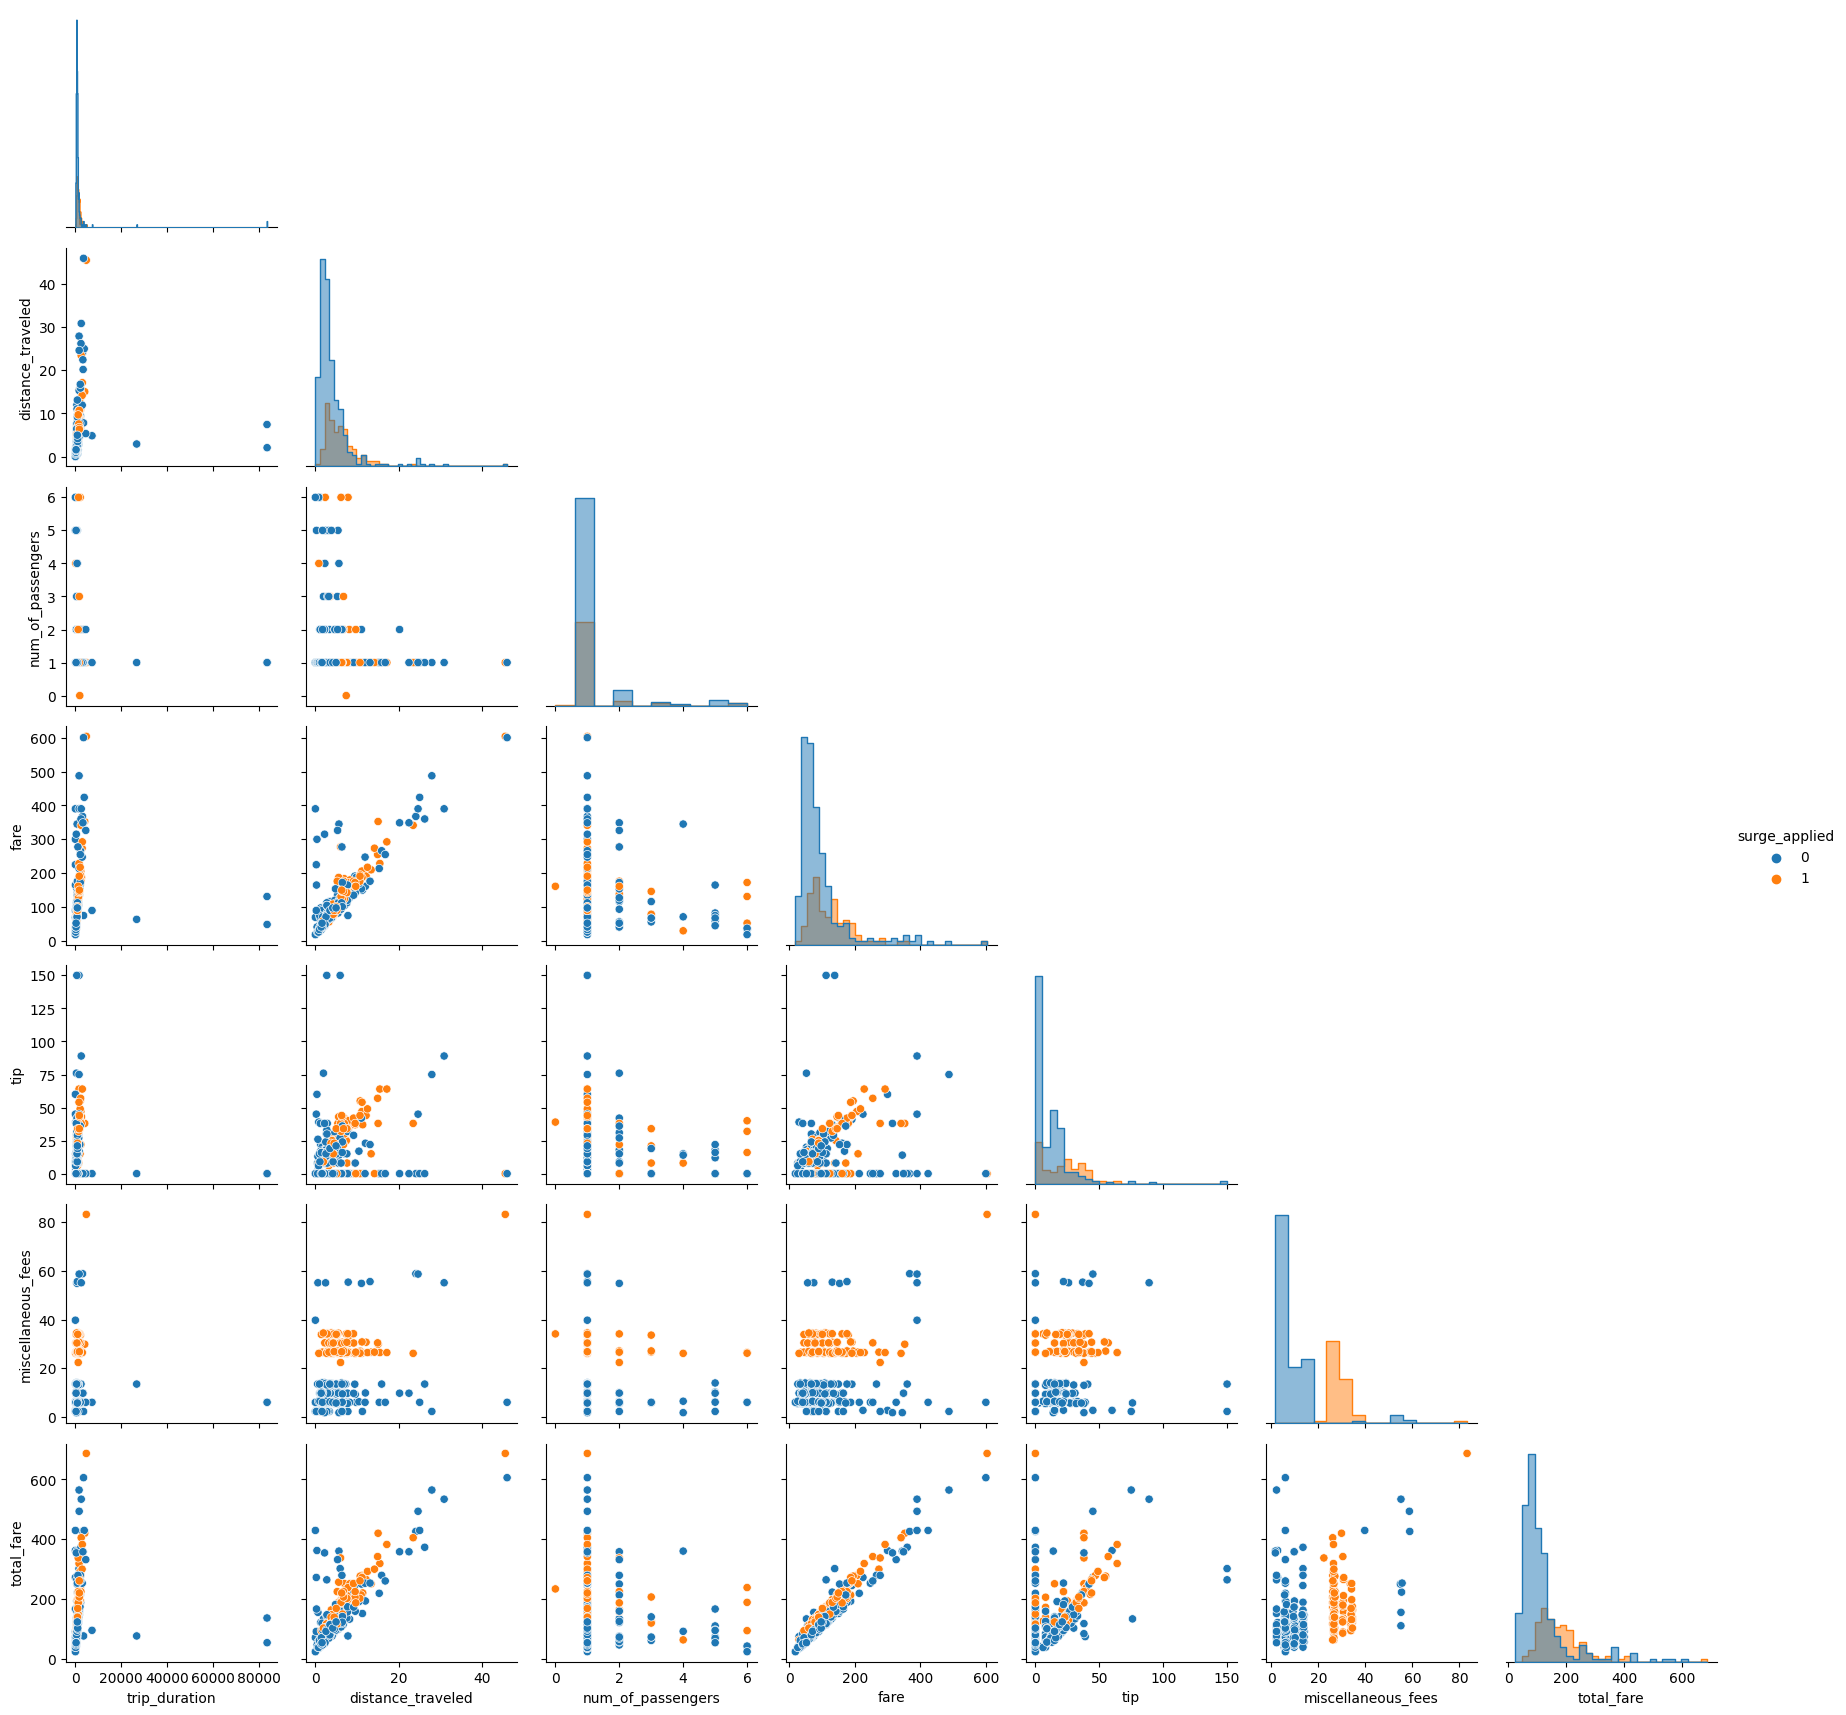

In [10]:
# Look for correlations bewteen variables
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce sample size for optimizing computational resources
train_sample_df = train_clean.sample(n=400,random_state=42)
# Only plot lower triangular relations
g = sns.PairGrid(train_sample_df,diag_sharey=False,corner=True,hue='surge_applied')
g.map_diag(sns.histplot,element='step',alpha=0.5)
g.map_lower(sns.scatterplot)
g.add_legend()

In [11]:
# We need to handle the outliers from trip duration using the 1.5*IQR rule
IQR = train_clean['trip_duration'].quantile(q=0.75) - train_clean['trip_duration'].quantile(q=0.25)
upper = train_clean['trip_duration'].quantile(q=0.75) + 1.5*IQR
print("Rows with outliers in trip duration:",train_clean[train_clean['trip_duration']>upper].shape[0])

# Drop outliers
train_clean = train_clean[train_clean['trip_duration']<=upper]

Rows with outliers in trip duration: 11623


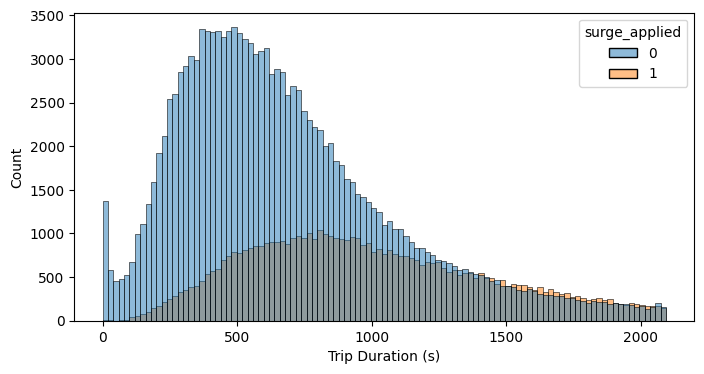

In [12]:
# Look at trip duration histogram after removing outliers
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(train_clean,x='trip_duration',hue='surge_applied',ax=ax,common_norm=False)
ax.set_xlabel("Trip Duration (s)")
plt.show()

In [13]:
# Convert to proper units trip duration (s) -> (hr)
train_clean['trip_duration'] = train_clean['trip_duration']/3600

In [14]:
# Engineer average speed feature
avg_spd = train_clean['distance_traveled']/train_clean['trip_duration'] #km/hr
train_clean['avg_speed'] = avg_spd
# Drop distance and time columns
train_clean.drop(['distance_traveled','trip_duration'],axis=1,inplace=True)


In [15]:
# Remove outliers
IQR = train_clean['avg_speed'].quantile(q=0.75) - train_clean['avg_speed'].quantile(q=0.25)
upper = train_clean['avg_speed'].quantile(q=0.75) + 1.5*IQR
train_clean = train_clean[train_clean['avg_speed']<=upper]

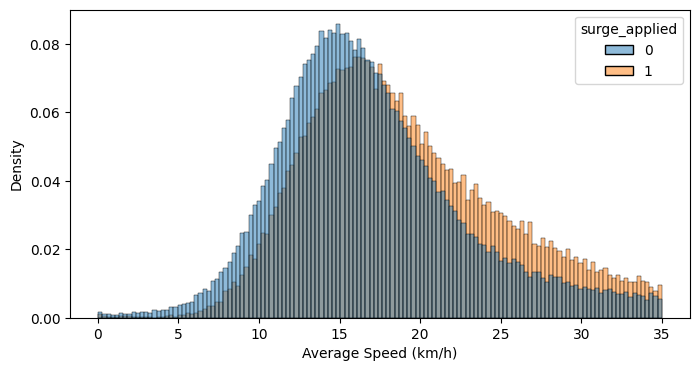

In [16]:
# Look at distribution of engineered parameter
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(train_clean,x='avg_speed',hue='surge_applied',ax=ax,stat='density',common_norm=False)
ax.set_xlabel("Average Speed (km/h)")
plt.show()

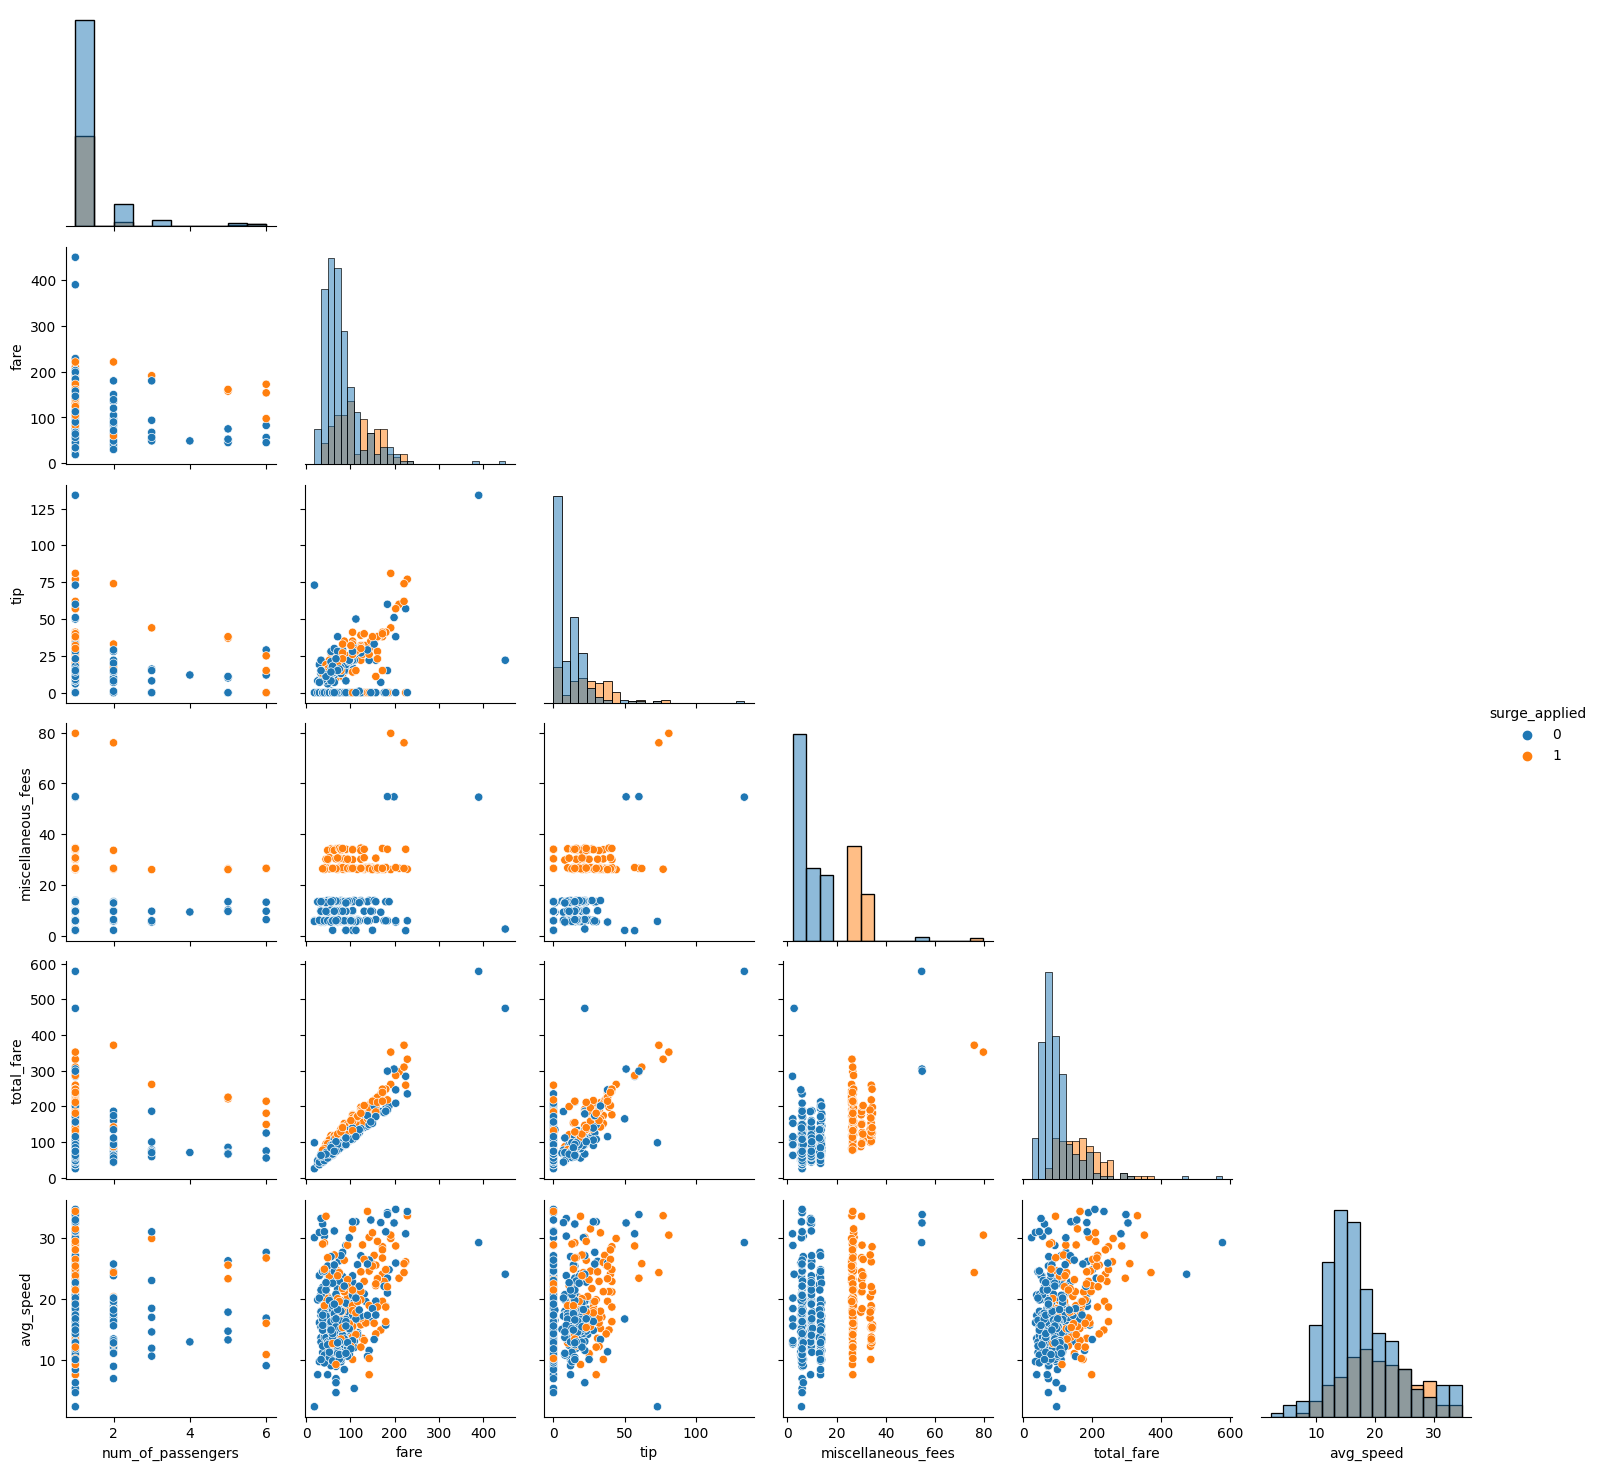

In [17]:
train_sample_df = train_clean.sample(n=400,random_state=42)
g = sns.PairGrid(train_sample_df,diag_sharey=False,corner=True,hue='surge_applied')
g.map_diag(sns.histplot,alpha=0.5,common_norm=False)
g.map_lower(sns.scatterplot)
g.add_legend()

In [18]:
# Check for class balance for surge_applied
train_clean['surge_applied'].value_counts(normalize=True)

0    0.717061
1    0.282939
Name: surge_applied, dtype: float64

From the previous line of code we see that the class balance between no-surge applied to surge applied is approximately 70-30 which is okay to work with. However, we can study the effects of class balancing and see what methods produces better results under the 4 metrics `accuracy`, `precision`, `recall` and `f1`.

In [19]:
from sklearn.utils import resample
# There is a class inbalance so we will upsample the minority class (surge wass applied) = 1
surge = train_clean[train_clean['surge_applied']==1]
no_surge = train_clean[train_clean['surge_applied']==0]

# Upsample minority class
minority_upsample = resample(surge,replace=True,n_samples=len(no_surge),random_state=2)

# Combine majority class with upsample minority class
train_balanced = pd.concat([no_surge,minority_upsample]).reset_index(drop=True)

# Display new class balance
train_balanced['surge_applied'].value_counts(normalize=True)

0    0.5
1    0.5
Name: surge_applied, dtype: float64

# Building and Cross Validating a Random Forest Classifier

In [20]:
# Relevant imports
# For cross validating
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
# For metric evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay
# For ensembling the random forest
from sklearn.ensemble import RandomForestClassifier

Due to the tremendous size of the data set we require a lot of computational resources to cross validate a random forest with a dataset with 200,000+ rows. Therefore, we will randomly sample from the balanced and inbalanced datasets smaller sample sizes.

In [21]:
# Define sample size
N = 50000
# Randomly sample the datasets
sample_balance = train_balanced.sample(n=N,random_state=42)
sample_imbalance = train_clean.sample(n=N,random_state=42)

sample_balance['surge_applied'].value_counts(normalize=True)

1    0.50216
0    0.49784
Name: surge_applied, dtype: float64

In [22]:
# Split data frame into labels (y) and features (X)
yb = sample_balance['surge_applied']
yi = sample_imbalance['surge_applied']

Xb = sample_balance.copy()
Xb = Xb.drop("surge_applied", axis = 1)

Xi = sample_imbalance.copy()
Xi = Xi.drop('surge_applied',axis=1)

# Split data into training and testing sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.25, stratify=yb, random_state=42)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.25, stratify=yi, random_state=42)

## Instantiate random forest classifier for balanced and imbalanced datasets

In [23]:
# Instantiate the Random Forest Classifier
rfb = RandomForestClassifier(random_state=0)
rfi = RandomForestClassifier(random_state=0)

# Define hyperparameters for CV to search over
cv_params = {'max_depth': [2,3], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100]
             }

# Deine the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the cross validated random forest
rfb_cv = GridSearchCV(rfb, cv_params, scoring=scoring, cv=5, refit='f1')
rfi_cv = GridSearchCV(rfi, cv_params, scoring=scoring, cv=5, refit='f1')

### Things to consider with `GridSearchCV` runtimes
* **Reduce the Search Space**:
Limit the Parameter Grid: Narrow down the search space by reducing the number of hyperparameters and their possible values in your param_grid. Focus on the most impactful parameters.
Coarse-to-Fine Search: Start with a coarse grid and then refine it based on initial results. This way, you explore promising regions first.

* **Parallelization**:
You mentioned parallelization, which is great! Ensure that you’re using all available CPU cores `n_jobs=-1`.
If you’re still facing performance issues, consider using a more powerful machine or a cloud-based solution with better computational resources.

* **Randomized Search**:
Instead of an exhaustive grid search, try a randomized search (`RandomizedSearchCV`). It randomly samples hyperparameters, which can be faster than an exhaustive search.

* **Feature Selection**:
If your dataset has many features, consider feature selection techniques (e.g., Recursive Feature Elimination) to reduce dimensionality. Fewer features can speed up training.

* **Smaller Subset for Initial Testing**:
Use a smaller subset of your data for initial testing. Once you find promising hyperparameters, then apply them to the entire dataset.

* **Preprocessing Optimization**:
Optimize data preprocessing steps (scaling, encoding, imputation) to reduce the time spent on data preparation.

* **Model Complexity**:
Random Forests can be computationally expensive. Consider using simpler models (e.g., Decision Trees) initially to explore the parameter space.

In [24]:
%%time
# Fit inbalanced model
# rfi_cv.fit(Xi_train,yi_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
%%time
# Fit balanced model
# rfb_cv.fit(Xb_train,yb_train)

CPU times: total: 0 ns
Wall time: 0 ns


### Save models as .pickle files

In [26]:
import pickle
# Save both models
# with open("rf_cv_balanced.pickle","wb") as to_write:
#     pickle.dump(rfb_cv,to_write)

# with open("rf_cv_imbalanced.pickle","wb") as to_write:
#     pickle.dump(rfi_cv,to_write)

Training the models is taking way too much time, so we will use parallel computing to reduce processing times

In [27]:
import multiprocessing

def parallelized_cross_validation(X, y, model, n_folds, pool):
    kf = KFold(n_folds)
    results = pool.map(single_fold_score, [(X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test], model) for train, test in kf.split(X)])
    return results

def single_fold_score(packaged_data):
    X_train, y_train, X_test, y_test, model = packaged_data
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def main_balanced():
    # Parallelize cross-validation
    with multiprocessing.Pool(processes=6) as pool:
        scores = parallelized_cross_validation(Xb, yb, rfb_cv, 5, pool)
        pool.close()

    print("Best Parameters:", rfb_cv.best_params_)
    print("Best Cross Validation Score:", rfb_cv.best_score_)

    # Return the cross-validated Random Forest classifier
    return rfb_cv.best_estimator_

def main_imbalanced():
    # Parallelize cross-validation
    with multiprocessing.Pool(processes=6) as pool:
        scores = parallelized_cross_validation(Xi, yi, rfi_cv, 5, pool)
        pool.close()

    print("Best Parameters:", rfi_cv.best_params_)
    print("Best Cross Validation Score:", rfi_cv.best_score_)

    # Return the cross-validated Random Forest classifier
    return rfi_cv.best_estimator_

In [28]:
# Load imbalanced cvrf and balanced cvrf
with open("rf_cv_imbalanced.pickle","rb") as to_read:
    rfi_cv = pickle.load(to_read)

with open("rf_cv_balanced.pickle","rb") as to_read:
    rfb_cv = pickle.load(to_read)

### Train the cross-validated random forest with the balanced data.

In [29]:
# Look at best params for each model
print("Balanced CVRF")
print(rfb_cv.best_params_)
print("Best score:",rfb_cv.best_score_)
print()
print("Imbalanced CVRF")
print(rfi_cv.best_params_)
print("Best score:",rfi_cv.best_score_)

Balanced CVRF
{'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9990977768986499

Imbalanced CVRF
{'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
Best score: 0.9985092000085498


In [30]:
# Compare each models predictions
yi_pred = rfi_cv.predict(Xi_test)

# The catch with the balanced cvrf need to be evaluated to our raw data 
# which is not balanced so let see how the balanced rf behaves with imbalanced data.
ybi_pred = rfb_cv.predict(Xi_test)

print("Balanced CVRF on Imbalanced Dataset Metrics:")
print("Precision Score:",round(precision_score(yi_test, ybi_pred),4))
print("Recall Score:",round(recall_score(yi_test, ybi_pred),4))
print("Accuracy Score:",round(accuracy_score(yi_test, ybi_pred),4))
print("F1 Score:",round(f1_score(yi_test, ybi_pred),4))
print()
print("Imbalanced Dataset Metrics:")
print("Precision Score:",round(precision_score(yi_test, yi_pred),4))
print("Recall Score:",round(recall_score(yi_test, yi_pred),4))
print("Accuracy Score:",round(accuracy_score(yi_test, yi_pred),4))
print("F1 Score:",round(f1_score(yi_test, yi_pred),4))

Balanced CVRF on Imbalanced Dataset Metrics:
Precision Score: 0.9975
Recall Score: 1.0
Accuracy Score: 0.9993
F1 Score: 0.9987

Imbalanced Dataset Metrics:
Precision Score: 0.998
Recall Score: 0.9992
Accuracy Score: 0.9992
F1 Score: 0.9986


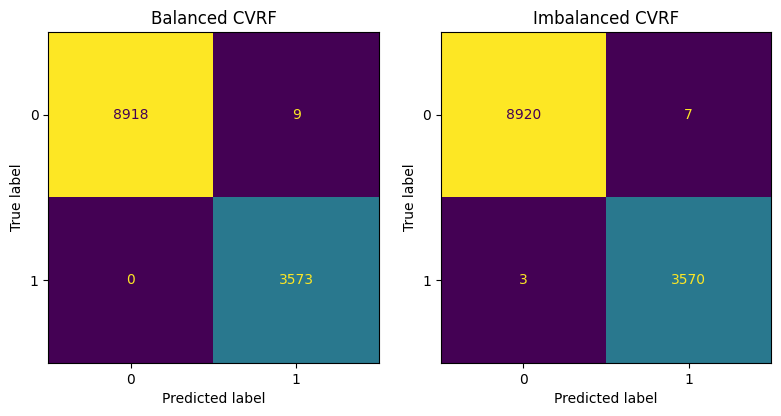

In [31]:
# Plot confusion matrices

cmb = confusion_matrix(yi_test, ybi_pred, labels=rfb_cv.classes_)
cmi = confusion_matrix(yi_test, yi_pred, labels=rfi_cv.classes_)

fig, (a0,a1) = plt.subplots(figsize=(8,4),ncols=2)
dispb = ConfusionMatrixDisplay(confusion_matrix=cmb, display_labels=rfb_cv.classes_)
dispi = ConfusionMatrixDisplay(confusion_matrix=cmi, display_labels=rfi_cv.classes_)
a0.set_title("Balanced CVRF")
a1.set_title("Imbalanced CVRF")
dispb.plot(ax=a0,colorbar=False)
dispi.plot(ax=a1,colorbar=False)
plt.tight_layout()


In [32]:
# We can create a pandas df to showcase the models
table = pd.DataFrame({"Model": ['CVRF with Balanced Data', 'CVRF with Imbalanced Data'],
                    "F1":[round(f1_score(yi_test, ybi_pred),4),round(precision_score(yi_test, yi_pred),4)],
                    "Accuracy":[round(accuracy_score(yi_test, ybi_pred),4),round(accuracy_score(yi_test, yi_pred),4)],
                    "Precision":[round(precision_score(yi_test, ybi_pred),4),round(precision_score(yi_test, yi_pred),4)],
                    "Recall":[round(recall_score(yi_test, ybi_pred),4),round(recall_score(yi_test, yi_pred),4)]})
table

,Model,F1,Accuracy,Precision,Recall
0,CVRF with Balanced Data,0.9987,0.9993,0.9975,1.0000
1,CVRF with Imbalanced Data,0.9980,0.9992,0.9980,0.9992


### There is an additional dataset for taxi fares specifically for testing, so we will run the model on this dataset

In [33]:
# Clean testing dataset
# Remove dubplicate rows 
test_df.drop_duplicates(inplace=True)

In [34]:
# Remove outliers from trip duration
# We need to handle the outliers from trip duration using the 1.5*IQR rule
IQR = test_df['trip_duration'].quantile(q=0.75) - test_df['trip_duration'].quantile(q=0.25)
upper = test_df['trip_duration'].quantile(q=0.75) + 1.5*IQR
print("Rows with outliers in trip duration:",test_df[test_df['trip_duration']>upper].shape[0])

# Drop outliers
test_df = test_df[test_df['trip_duration']<=upper]

Rows with outliers in trip duration: 4970


In [35]:
# Change units of trip duration from s -> hr
test_df['trip_duration'] = test_df['trip_duration']/3600

# Engineer average speed feature
avg_spd = test_df['distance_traveled']/test_df['trip_duration'] #km/hr
test_df['avg_speed'] = avg_spd

# Drop distance and time columns
test_df.drop(['distance_traveled','trip_duration'],axis=1,inplace=True)


In [36]:
# Remove outliers
IQR = test_df['avg_speed'].quantile(q=0.75) - test_df['avg_speed'].quantile(q=0.25)
upper = test_df['avg_speed'].quantile(q=0.75) + 1.5*IQR
test_df = test_df[test_df['avg_speed']<=upper]

In [37]:
# Separate features from target variable
Y = test_df['surge_applied']
X = test_df.copy()
X = X.drop("surge_applied", axis = 1)

In [38]:
X.describe()

,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,avg_speed
count,78201.000000,78201.0,78201.000000,78201.000000,78201.0,78201.000000
mean,1.288091,0.0,11.784568,14.493773,0.0,17.520223
std,0.929184,0.0,14.884635,10.784268,0.0,5.972501
min,0.000000,0.0,0.000000,-0.500000,0.0,0.064478
25%,1.000000,0.0,0.000000,6.000000,0.0,13.397089
50%,1.000000,0.0,9.000000,9.750000,0.0,16.603774
75%,1.000000,0.0,19.000000,26.450000,0.0,20.791837
max,9.000000,0.0,719.000000,304.125000,0.0,35.027027


In [39]:
# Predict wth balance and imbalanced cvrf
YPred_ba = rfb_cv.predict(X)
YPred_im = rfi_cv.predict(X)

In [40]:
table_2 = pd.DataFrame({"Model": ['CVRF with Balanced Data', 'CVRF with Imbalanced Data'],
                    "F1":[round(f1_score(Y, YPred_ba),4),round(precision_score(Y, YPred_im),4)],
                    "Accuracy":[round(accuracy_score(Y, YPred_ba),4),round(accuracy_score(Y, YPred_im),4)],
                    "Precision":[round(precision_score(Y, YPred_ba),4),round(precision_score(Y, YPred_im),4)],
                    "Recall":[round(recall_score(Y, YPred_ba),4),round(recall_score(Y, YPred_im),4)]})
table_2

,Model,F1,Accuracy,Precision,Recall
0,CVRF with Balanced Data,0.9984,0.9991,0.9975,0.9993
1,CVRF with Imbalanced Data,0.9980,0.9978,0.9980,0.9943


The cross validated random forest (CVRF) classifier trained with balanced data is marginally superior to the CVRF trained with imbalanced data on all metric except `Precision`.

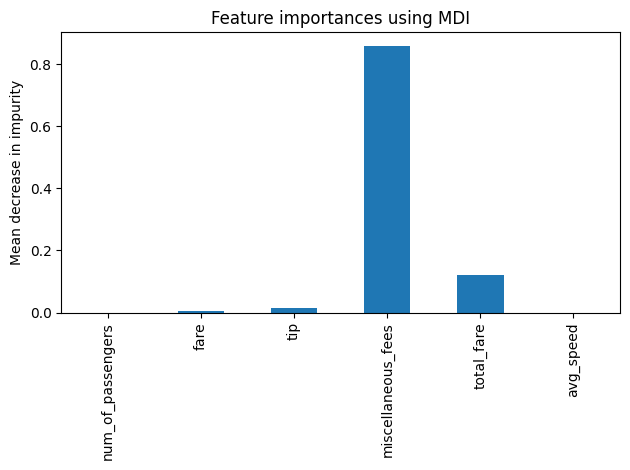

In [58]:
# Lets look at the feature importance for he champion model
importance = rfb_cv.best_estimator_.feature_importances_
#std = np.std([tree.feature_importances_ for tree in rfb_cv.estimator], axis=0)
forest_importance = pd.Series(importance,index=rfb_cv.feature_names_in_)

fig, ax = plt.subplots()
forest_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()